#### Predection PAs
<small> looking at the three prior seasons

In [49]:
# packages and file import
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sys
function_dir = 'C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/tools'
sys.path.append(function_dir)
# wd
os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/')

In [50]:
pa_data = pd.read_csv('./data/cleaned/pa_injury_data.csv')
pa_data = pa_data.drop(columns=['Unnamed: 0'])

#### Change to Three Year Format

In [51]:
pa_data_23 = pa_data[pa_data['Season'] < 2024]

In [52]:
def three_year_avg(df):
    combined_rows = []
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col not in ['Season', 'Age']]  # exclude Season and Age from averaging

    for name, group in df.groupby('Name'):
        group_sorted = group.sort_values('Season')
        if len(group_sorted) < 3:
            continue
        for i in range(len(group_sorted) - 2):
            window = group_sorted.iloc[i:i+3]
            # Use the latest season and age in the window
            season_label = int(window.iloc[2]['Season'])
            age_label = window.iloc[2]['Age']
            # Average numeric columns (except Season, Age)
            averaged = window[numeric_cols].mean()
            new_row = {'Name': name, 'Season': season_label, 'Age': age_label}
            for col in numeric_cols:
                new_row[col] = averaged[col]
            combined_rows.append(new_row)

    avg_three = pd.DataFrame(combined_rows)
    avg_three['Age'] = avg_three['Age'] + 1
    return avg_three


In [53]:
pa_data_3 = three_year_avg(pa_data_23)
pa_data_24 = pa_data[pa_data['Season'] == 2024]
pa_data_combined = pd.concat([pa_data_3, pa_data_24], ignore_index=True)

#### Normalize

In [54]:
from tools.zscore import normalize
df_zscore = normalize(pa_data_combined)
df_zscore.head()

,Name,Season,Age,PA,Days_Missed_Season
0,aaron hicks,2023,110.018822,90.561277,119.021598
1,aaron judge,2023,104.033097,109.813881,102.276618
2,abraham almonte,2023,113.011685,76.315209,90.156442
3,abraham toro,2023,89.068783,87.488596,91.751202
4,adam duvall,2023,113.011685,97.695054,111.526226


#### xgboost model

In [55]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

get next year PA

In [56]:
for idx in df_zscore.index:
    # retrive name, season
    name = df_zscore.loc[idx, 'Name']
    season = df_zscore.loc[idx, 'Season']
    # full df
    next_year = pa_data[(pa_data['Name'] == name) & (pa_data['Season'] == season + 1)]
    # add to df
    if not next_year.empty:
        df_zscore.loc[idx, 'next_pa'] = next_year['PA'].iloc[0] # need for later anaylsis

df_zscore_train = df_zscore.dropna(subset=['next_pa'])

#### model training loop

In [57]:
X = df_zscore_train.drop(columns=['Name', 'Season', 'next_pa'])
y = df_zscore_train['next_pa']

In [58]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [59]:
model = xgb.XGBRegressor(n_estimators = 100, random_state = 26)
model.fit(train_x, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=26, ...)

##### hyperparameter search

random search

In [60]:
from sklearn.model_selection import RandomizedSearchCV

In [61]:
rnd_search_params = {
    'learning_rate': np.linspace(0.05, 0.2, 4),          
    'max_leaves': np.linspace(1, 40, 20, dtype=int),     
    'min_child_weight': np.linspace(1, 20, 10),         
    'subsample': np.linspace(0.3, 0.9, 7),               
    'colsample_bytree': np.linspace(0.4, 1, 7),          
    'early_stopping_rounds': np.linspace(10, 100, 10, dtype=int),  
    'max_depth': np.linspace(0, 40, 20, dtype=int)       
}

rnd_searcher = RandomizedSearchCV(model, rnd_search_params, random_state=26, n_iter=1000, cv=5, n_jobs=-1, verbose=4)
rnd_searcher.fit(train_x, train_y, eval_set=[(test_x, test_y)])
print(rnd_searcher.best_params_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


KeyboardInterrupt: 

grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
grid_search_params = {
    'learning_rate': [0.1, 0.15],   
    'max_leaves': [10, 11, 12],
    'min_child_weight': [17, 18, 19],      
    'subsample': [0.45, 0.5, 0.55],           
    'colsample_bytree':[0.8, 0.9, 1],     
    'early_stopping_rounds':[30, 40, 50],
    'max_depth': [2, 3, 4]
}
grid_searcher = GridSearchCV(model, grid_search_params, cv=5, n_jobs=-1, verbose=4)
grid_searcher.fit(train_x, train_y, eval_set=[(test_x, test_y)])
print(grid_searcher.best_params_)

Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
[0]	validation_0-rmse:10.10173
[1]	validation_0-rmse:9.95633
[2]	validation_0-rmse:9.92221
[3]	validation_0-rmse:9.87552
[4]	validation_0-rmse:9.82120
[5]	validation_0-rmse:9.75860
[6]	validation_0-rmse:9.74848
[7]	validation_0-rmse:9.65598
[8]	validation_0-rmse:9.56320
[9]	validation_0-rmse:9.51945
[10]	validation_0-rmse:9.48473
[11]	validation_0-rmse:9.46895
[12]	validation_0-rmse:9.43942
[13]	validation_0-rmse:9.44393
[14]	validation_0-rmse:9.45946
[15]	validation_0-rmse:9.48480
[16]	validation_0-rmse:9.40626
[17]	validation_0-rmse:9.32923
[18]	validation_0-rmse:9.33647
[19]	validation_0-rmse:9.34183
[20]	validation_0-rmse:9.36188
[21]	validation_0-rmse:9.41052
[22]	validation_0-rmse:9.40377
[23]	validation_0-rmse:9.39613
[24]	validation_0-rmse:9.39234
[25]	validation_0-rmse:9.41144
[26]	validation_0-rmse:9.38539
[27]	validation_0-rmse:9.47325
[28]	validation_0-rmse:9.41554
[29]	validation_0-rmse:9.45614
[30]	validatio

In [62]:
opti_para = {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 2, 'max_leaves': 10, 'min_child_weight': 18, 'subsample': 0.5}
model.set_params(**opti_para, n_estimators = 75, early_stopping_rounds = None)
model.fit(train_x, train_y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=10, min_child_weight=18, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=75,
             n_jobs=None, num_parallel_tree=None, random_state=26, ...)

##### results

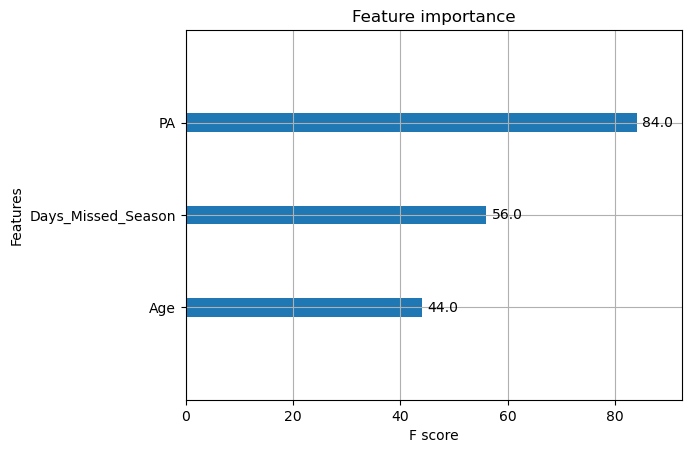

In [63]:
xgb.plot_importance(model)
plt.show()

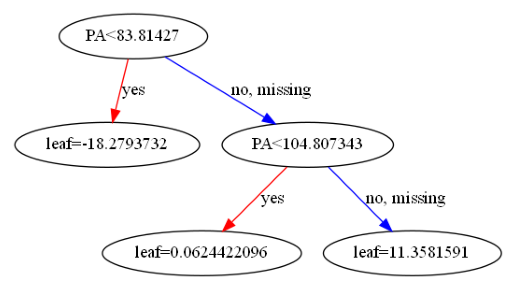

In [64]:
xgb.plot_tree(model, num_trees=3)
plt.show()

In [65]:
results = model.predict(test_x)
rmse = root_mean_squared_error(y_pred=results, y_true=test_y)
print(rmse)

156.20087609607813


#### 2025 Predections

In [66]:
pred_data_25 = pa_data[pa_data['Season'] > 2021]
predection_set = three_year_avg(pred_data_25)
predection_set = normalize(predection_set)

In [67]:
x_predections = predection_set.drop(columns=['Name', 'Season'])
xgb_final_preds = model.predict(x_predections)

In [69]:
pred_2025 = predection_set.copy()
pred_2025['pred_pa'] = xgb_final_preds

In [71]:
export_pred = pred_2025[['Name', 'pred_pa']]
export_pred = export_pred.reset_index()
export_pred = export_pred.drop(columns='index')
export_pred.to_csv('./predicted_data/pa_25_3.csv')